In [71]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GT rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
GT Mode 0: [-5. -5. -5.] +/- [0.5 0.5 0.5]
GT Mode 1: [5. 5. 5.] +/- [0.25 0.25 0.25]
GT Mode 2: [-2.  0.  2.] +/- [2.  1.  0.5]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

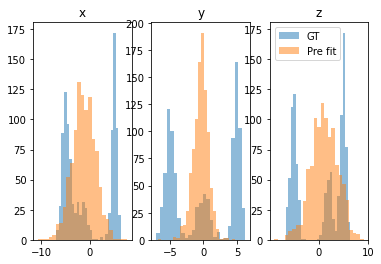

In [72]:
# Make the ground truth GMM grammar.
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-5., -5., -5.]),
    torch.tensor([5., 5., 5.]),
    torch.tensor([-2., 0., 2.])
]
desired_mode_vars = [
    torch.tensor([0.5, 0.5, 0.5]),
    torch.tensor([0.25, 0.25, 0.25]),
    torch.tensor([2., 1., 0.5])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.2])
rule_probs_param = gt_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))

# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(2)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
#fit_grammar = deepcopy(gt_grammar)
pre_fit_grammar = deepcopy(fit_grammar)
if 0:
    # Initialize with nicely-separated initial peaks:
    rule_probs_param = pre_fit_grammar.params_by_node_type[Root.__name__]
    print("Pre-fit rule probs: ", rule_probs_param())
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        mean_param.set((torch.ones(3)*k - torch.ones(3)) * 3.)
        var_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        var_param.set(torch.ones(3) * 0.1)
        print("Pre-fit Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))


def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=25, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=25, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

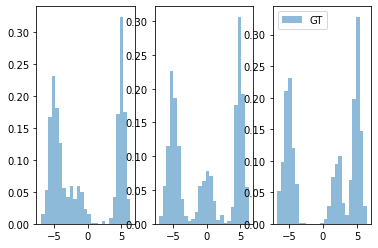

In [73]:
torch.random.manual_seed(43)
N_fit_samples = 500

# Draw an actual fitting dataset.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)

l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.5, bins=25, density=True)
    plt.hist(l_gt[:, k], label="GT", alpha=0.5, bins=25, density=True)
    if k == 2:
        plt.legend()

EM fit rule probs:  tensor([0.4051, 0.1896, 0.4053], grad_fn=<DivBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-0.0368,  0.0118, -0.0773], requires_grad=True) +/- tensor([10.0000, 10.0000, 10.0000], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-2.1631, -0.1328,  1.8831], requires_grad=True) +/- tensor([1.5071, 0.9402, 0.4904], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-0.0368,  0.0118, -0.0773], requires_grad=True) +/- tensor([10.0000, 10.0000, 10.0000], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

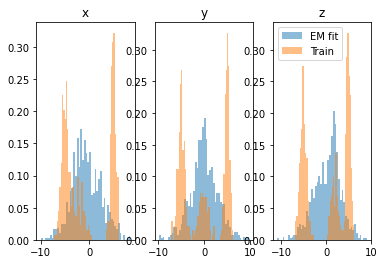

In [74]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)

# Initialize param guesses from pre-fit grammar
param_guesses = {
    "mode_weights": pre_fit_grammar.params_by_node_type[Root.__name__]().detach()
}
for mode in Modes:
    mode_name = mode.__name__
    mean = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach()
    var = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach()
    param_guesses[mode_name] = {
        "mean": mean,
        "var": var
    }

N_iters = 10
points = torch.stack([sample[1][0].translation for sample in samples]) # N x 3
for iter_k in range(N_iters):
    # Associate each sample with the MAP cluster
    dists = [
        dist.Normal(
            param_guesses[mode.__name__]["mean"],
            param_guesses[mode.__name__]["var"])
        for mode in Modes
    ]
    # Get scores for each mode for each point.
    point_log_probs = torch.stack([
        dist.log_prob(points).sum(axis=1) for dist in dists
    ], axis=-1) # N x N_dists
    # Multiply in prob of that cluster being active
    point_log_probs = point_log_probs + param_guesses["mode_weights"]
    # Normalize for a given point
    point_log_probs = (point_log_probs.T - torch.logsumexp(point_log_probs, axis=-1)).T
    w = torch.exp(point_log_probs)
    
    # New weight guesses are average of weights
    new_weights = torch.mean(w, axis=0) + 1E-4
    new_weights = new_weights / torch.sum(new_weights)
    param_guesses["mode_weights"] = new_weights
    # New mean is weighted sum of observed locations
    for k, mode in enumerate(Modes):
        new_mean = torch.sum(w[:, k] * points.T, axis=1) / torch.sum(w[:, k])
        offsets = points - new_mean
        new_var = torch.sum(w[:, k] * torch.square(offsets).T, axis=1) / torch.sum(w[:, k]) + 1E-4
        param_guesses[mode.__name__]["mean"] = new_mean
        param_guesses[mode.__name__]["var"] = new_var
# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(param_guesses["mode_weights"])
print("EM fit rule probs: ", rule_probs_param())
for mode in Modes:
    mode_name = mode.__name__
    mean_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    var_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    mean_param.set(param_guesses[mode_name]["mean"])
    var_param.set(param_guesses[mode_name]["var"])
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_em_fit[:, k], bins=50, label="EM fit", alpha=0.5, density=True)
    plt.hist(l_train[:, k], bins=50, label="Train", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# One-shot parsing with MAP point latent estimates

In [75]:
# Do single-shot fitting of grammar params based on just the optimal parses
# Use SVI wrapper to collect MAP trees (maybe this should be split out)
one_shot_fit_grammar = deepcopy(pre_fit_grammar)
em = EMWrapper(one_shot_fit_grammar, [sample[1] for sample in samples])
em.do_iterated_em_fitting(em_iterations=5, tqdm=tqdm, N_solutions=3, num_workers=10);

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Final params:  tensor([0.4080, 0.1900, 0.4020])


GaussianMode_0 :
mean tensor([[-1.3265, -1.2413, -0.1028],
        [-0.5454, -0.4674, -0.4354],
        [-4.4929, -4.2047, -4.0777],
        [-4.9898, -4.8767, -4.9416],
        [-5.0070, -4.9318, -5.0462],
        [-5.0070, -4.9318, -5.0462]])
0:xyz:mean final: tensor([-5.0070, -4.9318, -5.0462])
variance tensor([[ 9.4140,  1.9705,  7.5793],
        [10.0000, 10.0000, 10.0000],
        [ 3.2842,  4.5714,  6.9013],
        [ 0.5772,  0.7727,  1.2613],
        [ 0.5408,  0.5828,  0.5877],
        [ 0.5408,  0.5828,  0.5877]])
0:xyz:variance final: tensor([0.5408, 0.5828, 0.5877])
GaussianMode_1 :
mean tensor([[-1.2050, -0.1633,  1.5277],
        [-1.9410,  0.0424,  1.9775],
        [-2.1454, -0.0983,  1.9220],
        [-2.0999, -0.0837,  1.8978],
        [-2.1640, -0.1329,  1.8836],
        [-2.1640, -0.1329,  1.8836]])
0:xyz:mean final: tensor([-2.1640, -0.1329,  1.8836])
variance tensor([[4.6226, 0.8209, 6.8300],
        [2.6620, 1.3593, 0.8364],
        [1.3638, 0.8052, 0.4493],
    

GaussianMode_2 :
mean tensor([[ 0.3923, -0.2236, -0.3195],
        [ 4.6773,  5.0050,  4.2655],
        [ 5.0133,  5.0326,  4.9633],
        [ 5.0105,  5.0293,  4.9632],
        [ 5.0105,  5.0293,  4.9632],
        [ 5.0105,  5.0293,  4.9632]])
0:xyz:mean final: tensor([5.0105, 5.0293, 4.9632])
variance tensor([[9.1326, 5.2571, 1.2041],
        [3.5309, 3.2571, 1.6667],
        [0.2391, 0.2432, 0.2349],
        [0.2392, 0.2441, 0.2352],
        [0.2392, 0.2441, 0.2352],
        [0.2392, 0.2441, 0.2352]])
0:xyz:variance final: tensor([0.2392, 0.2441, 0.2352])


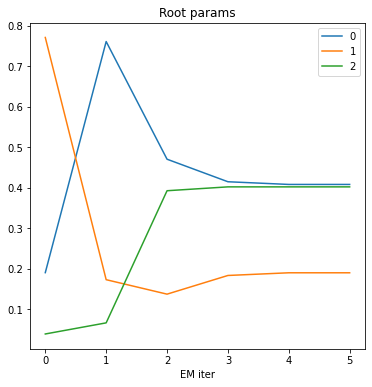

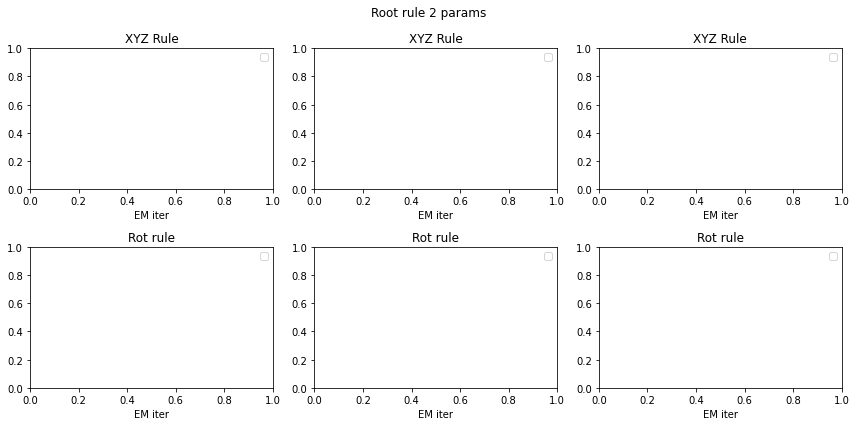

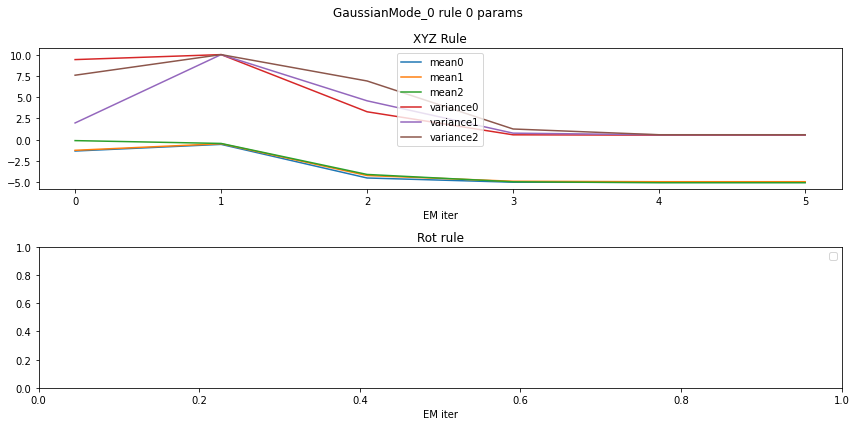

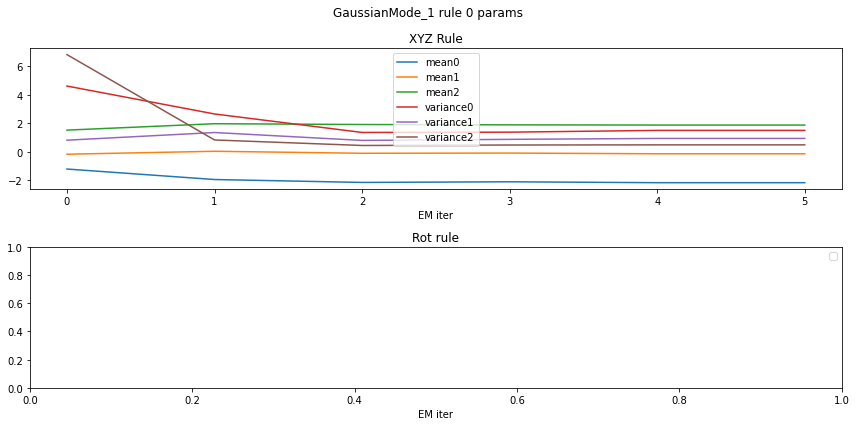

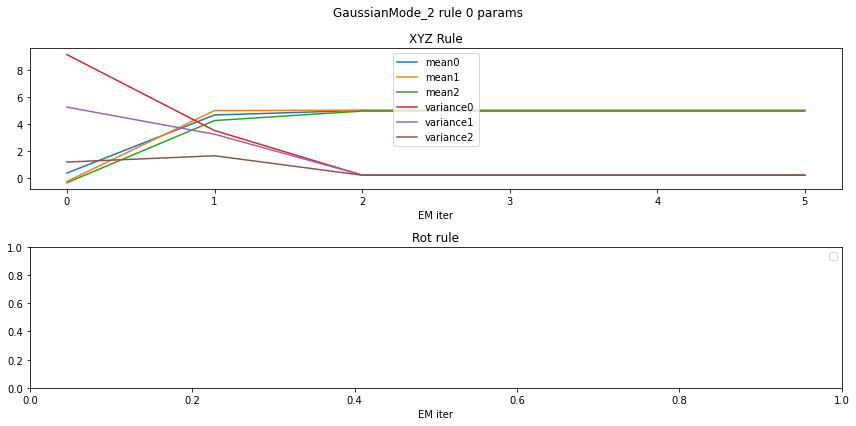

In [76]:
em.plot_grammar_parameter_history(Root)
for mode in Modes:
    print(mode.__name__, ":")
    em.plot_grammar_parameter_history(mode)

  0%|          | 0/1000 [00:00<?, ?it/s]

One shot fit rule probs:  tensor([0.1903, 0.7707, 0.0390], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.2050, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([ 0.3923, -0.2236, -0.3195], requires_grad=True) +/- tensor([9.1326, 5.2571, 1.2041], grad_fn=<AddBackward0>)


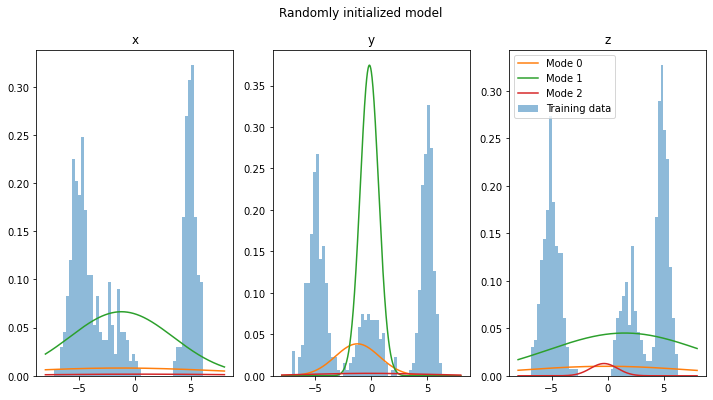

In [77]:
%matplotlib inline
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
def make_figure_for_grammar(one_shot_fit_grammar, axs, N=1000):
    rule_probs_param = one_shot_fit_grammar.params_by_node_type[Root.__name__]
    print("One shot fit rule probs: ", rule_probs_param())
    modes = []
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        var_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        modes.append((mean_param(), var_param()))
        print("One shot-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))

    #fit_samples = get_draws_from_grammar(one_shot_fit_grammar, N)
    l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
    l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
    l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
    xs = np.linspace(-8, 8, 1000)
    for k, label in enumerate("xyz"):
        ax = axs[k]
        ax.hist(l_train[:, k], bins=50, label="Training data", alpha=0.5, density=True)
        #ax.hist(l_gt[:, k], bins=50, label="Test data", alpha=0.5, density=True)
        #plt.hist(l_fit[:, k], bins=50, label="One-shot fit", alpha=0.5, density=True)
        # Plot the mode density
        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            ax.plot(xs, mode, label="Mode %d" % mode_k)
        ax.set_title(label)
        if k == 2:
            plt.legend()
            
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
plt.suptitle("Randomly initialized model")

one_shot_fit_grammar.load_state_dict(em.grammar_iters[0])
make_figure_for_grammar(one_shot_fit_grammar, axs)

In [78]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")

def update(frame):
    one_shot_fit_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(one_shot_fit_grammar, axs, N=1000)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.1903, 0.7707, 0.0390], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.2050, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([ 0.3923, -0.2236, -0.3195], requires_grad=True) +/- tensor([9.1326, 5.2571, 1.2041], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.1903, 0.7707, 0.0390], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.2050, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter con

# MLE gradient-descent parsing with point latent estimates

In [79]:
# Do MLE via gradient descent
svi = SVIWrapper(fit_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(major_iterations=1, minor_iterations=200, base_lr=0.01, subsample=None, tqdm=tqdm, clip=None, N_solutions=3, N_workers=10)

TypeError: do_iterated_vi_fitting() got an unexpected keyword argument 'N_workers'

In [ ]:
svi.plot_elbo_history()
print("Fit mode probs: ", fit_grammar.params_by_node_type[Root.__name__]())
for mode in Modes:
    print("Mode " , mode)
    svi.plot_grammar_parameter_history(mode)
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.25)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5)
    plt.hist(l_fit[:, k], bins=100, label="Post fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()